Стандартные бибилиотеки

In [1]:
!! pip install pymorphy2  # для лемматизации
!! pip install wordcloud  # для облака слов
# !! pip install navec  # аналог glove для русских слов
!! pip install sentence_transformers

['Collecting sentence_transformers',
 '  Downloading sentence_transformers-3.1.1-py3-none-any.whl.metadata (10 kB)',
 'Requirement already satisfied: transformers<5.0.0,>=4.38.0 in /usr/local/lib/python3.10/dist-packages (from sentence_transformers) (4.44.2)',
 'Requirement already satisfied: tqdm in /usr/local/lib/python3.10/dist-packages (from sentence_transformers) (4.66.5)',
 'Requirement already satisfied: torch>=1.11.0 in /usr/local/lib/python3.10/dist-packages (from sentence_transformers) (2.4.1+cu121)',
 'Requirement already satisfied: scikit-learn in /usr/local/lib/python3.10/dist-packages (from sentence_transformers) (1.5.2)',
 'Requirement already satisfied: scipy in /usr/local/lib/python3.10/dist-packages (from sentence_transformers) (1.13.1)',
 'Requirement already satisfied: huggingface-hub>=0.19.3 in /usr/local/lib/python3.10/dist-packages (from sentence_transformers) (0.24.7)',
 'Requirement already satisfied: Pillow in /usr/local/lib/python3.10/dist-packages (from sent

В папке на диске лежит файл *navec_hudlit_v1_12B_500K_300d_100q.tar* - это русский векторайзер

Скачать и заюзать можете по ссылке https://drive.google.com/file/d/1zkqdVLpmTxT58mOlrD5SYBUvBCwjk1zv/view?usp=sharing

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import os

# os.chdir(r'/content/gdrive/MyDrive/МТС')
# print(os.getcwd())

/content/gdrive/MyDrive/МТС


In [2]:
from sklearn.cluster import KMeans, kmeans_plusplus
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
from tqdm import tqdm
from wordcloud import WordCloud
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from gensim.models import KeyedVectors
# from navec import Navec
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pymorphy2
import seaborn as sns
import gensim
import nltk

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Убрем здесь стопслова. Осталось придумать, что делать с "не" и отрицательным смыслом

In [10]:
# Загрузка необходимых данных
nltk.download('stopwords')

# Получение списка русских стоп-слов

stopwords_ru = stopwords.words("russian")

# Вывод первых 10 стоп-слов
reg_stop = '|'.join(map(lambda x: f'(^{x}$)', stopwords_ru)) + '|(^из-за$)|(^из-под$)'#|(^.*[иы]й$)' # в стоп-словах не было этих союзов + я убрал прилагательные, так как везде будет "большой", "любимый"
# reg_stop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
reg = r'[^А-Яа-я /-]'
bad_reg = r'(.*ху.*)|(.*пиз.*)|(.*еба.*)|(.*еби.*)' + rf'|{reg_stop}'  # обработаем плохие слова и стоп слова
# На месте words будет чтение файла со словами
words = [
    "Возможность развиваться",
    "Команда",
    "Интересные задачи",
    "Удобный график",
    "Возможность обучаться",
    "Поддержка коллег",
    "Достижения",
    "Творческая атмосфера",
    "Взаимодействие с клиентами",
    "Работа с новыми технологиями",
    "Гибкий график",
    "Признание заслуг",
    "Профессиональный рост",
    "Участие в интересных проектах",
    "Разнообразие задач",
    "Чувство выполненного долга",
    "Хорошая рабочая атмосфера",
    "Конкурентоспособная зарплата",
    "Критическое мышление",
    "Обратная связь от руководства",
    "Соблюдение сроков",
    "Возможность работать удаленно",
    "Личное время",
    "Интересные встречи",
    "Решение сложных задач",
    "Непредсказуемость",
    "Взаимопомощь в команде",
    "Сплоченный коллектив",
    "Участие в тренингах",
    "Развитие навыков",
    "Забота о здоровье сотрудников",
    "Инновационные проекты",
    "Дружелюбная атмосфера",
    "Забавные коллеги",
    "Лидерство",
    "Мотивация",
    "Клиентская ориентированность",
    "Разнообразие стилей работы",
    "Наставничество",
    "Инициативность",
    "Личные достижения",
    "Международные проекты",
    "Обсуждение идей",
    "Четкое распределение ролей",
    "Прозрачность в компании",
    "Сложные проекты",
    "Работа в команде",
    "Динамичность",
    "Разнообразные подходы к задачам",
    "Хорошая организация",
    "Способы повышения эффективности",
    "Опыт работы с экспертами",
    "Культурные мероприятия",
    "Систематизация знаний",
    "Награды",
    "Позитивная обстановка",
    "Доступ к ресурсам",
    "Участие в конференциях",
    "Дискуссии на рабочие темы",
    "Работа с вдохновляющими людьми",
    "Работа с данными",
    "Поддержка инициатив",
    "Коммуникация",
    "Справедливое распределение нагрузки",
    "Работа с клиентами",
    "Разработка новых продуктов",
    "Гибкость в подходах",
    "Сотрудничество",
    "Финансовая стабильность",
    "Открытость к критике",
    "Систематическое обучение",
    "Постоянное саморазвитие",
    "Участие в важных решениях",
    "Поддержка от руководства",
    "Создание новых идей",
    "Работа с талантливыми людьми",
    "Уважение к личному времени",
    "Смена задач",
    "Соблюдение баланса между работой и личной жизнью",
    "Возможность путешествовать",
    "Технологические инновации",
    "Стабильность компании",
    "Доступ к обучающим материалам",
    "Работа с интересными проектами",
    "Гармония в команде",
    "Создание комфортных условий",
    "Благодарности от клиентов",
    "Хорошее настроение на работе",
    "Партнёрство",
    "Постоянная поддержка коллег",
    "Обсуждение результатов",
    "Работа с вдохновением",
    "Креативные идеи",
    "Качественное выполнение задач",
    "Обсуждение перспектив",
    "Индивидуальный подход",
    "Чувство значимости",
    "Стимулирование к успеху",
    "Участие в командных играх",
    "Постоянное взаимодействие",
    "Личная инициатива",
    "Развитие в профессии",
    "Обмен опытом",
    "Чувство безопасности",
    "Работа с лидерами отрасли",
    "Поиск новых решений",
    "Забота о коллегах",
    "Поддержка в трудные времена",
    "Обсуждение новых идей",
    "Создание комфортной рабочей среды",
    "Участие в корпоративной культуре",
    "Возможность выбора проектов",
    "Настройка рабочего процесса",
    "Общение с интересными людьми",
    "Принятие участия в мозговом штурме",
    "Открытость в коммуникации",
    "Гармония в коллективе",
    "Соблюдение личных границ",
    "Разработка новых стратегий",
    "Работа с широким кругом задач",
    "Обратная связь от клиентов",
    "Решение нестандартных задач",
    "Работа с программами",
    "Эффективное планирование",
    "Участие в стратегических планах",
    "Хорошие условия труда",
    "Возможность выразить свои мысли",
    "Поддержка личных инициатив",
    "Качественное взаимодействие",
    "Постоянное движение вперед",
    "Работа с высококлассными специалистами",
    "Понимание и поддержка со стороны коллег",
    "Интересные и творческие задачи",
    "Сплоченность команды",
    "Обмен мнениями",
    "Поддержание хороших отношений",
    "Гибкий подход к задачам",
    "Командные достижения",
    "Взаимное уважение",
    "Работа с динамичными проектами",
    "Возможность самовыражения",
    "Взаимодействие с разными отделами",
    "Обсуждение рабочих моментов",
    "Культура обсуждений",
    "Фокус на результат",
    "Создание новых возможностей",
    "Работа с позитивным настроем",
    "Открытость к новым идеям",
    "Профессиональные стандарты",
    "Результаты работы",
    "Обсуждение совместных проектов",
    "Инновационный подход",
    "Работа с мотивированными людьми",
    "Забота о своих сотрудниках",
    "Обратная связь от команды",
    "Чувство свободы в принятии решений",
    "Развитие креативного мышления",
    "Сложные и интересные проекты",
    "Работа с положительными результатами",
    "Сотрудничество между отделами",
    "Стимулирование профессионального роста",
    "Эмоциональная поддержка",
    "Работа с идеями на этапе разработки",
    "Формирование команды",
    "Открытое обсуждение",
    "Работа над амбициозными проектами",
    "Возможность работать над собой",
    "Способы повышения эффективности",
    "Создание новых идей",
    "Эмоциональный интеллект",
    "Разнообразие задач",
    "Доброжелательное общение",
    "Взаимная поддержка",
    "Участие в культурных мероприятиях",
    "Этичные принципы работы",
    "Поддержание позитивной атмосферы",
    "Работа в инновационной компании",
    "Поддержка личных ценностей",
    "Технологические решения",
    "Чувство вкладу в общую цель",
    "Постоянное совершенствование",
    "Работа с первоклассными материалами",
    "Разработка новых идей",
    "Командный дух",
    "Гармония в коллективе",
    "Чувство уважения к коллегам",
    "Лидерские качества",
    "Работа с профессионалами",
    "Стратегическое планирование",
    "Обсуждение проектов",
    "Непрерывное развитие",
    "Работа с высокими стандартами",
    "Качественная обратная связь",
    "Развитие коммуникационных навыков",
    "Доступность ресурсов",
    "Работа с интересными людьми",
    "Создание ценностей",
    "Возможность заниматься любимым делом",
    "Справедливое распределение задач",
    "Обсуждение рабочих моментов",
    "Работа с интересными клиентами",
    "Разработка уникальных решений",
    "Гибкий подход к задачам",
    "Эффективная коммуникация",
    "Создание дружеской атмосферы",
    "Работа в команде",
    "Творческий процесс",
    "Поддержка на уровне руководства",
    "Работа с людьми, которые вдохновляют",
    "Обсуждение идей",
    "Участие в жизненно важных проектах",
    "Доступность информации",
    "Работа над значимыми проектами",
    "Инновационные технологии",
    "Постоянное взаимодействие",
    "Работа с разными культурами",
    "Обратная связь от клиентов",
    "Чувство уверенности в своих силах",
    "Интересные семинары",
    "Непредсказуемые задачи",
    "Доброжелательность коллег",
    "Четкость задач",
    "Работа с нестандартными подходами",
    "Постоянное обновление знаний",
    "Участие в совместных мероприятиях",
    "Открытость к обсуждениям",
    "Чувство безопасности",
    "Команда единомышленников",
    "Интересные инициативы",
    "Личностный рост",
    "Работа в активном коллективе",
    "Забота о коллегах",
    "Работа с увлечением",
    "Создание новых идей",
    "Творческий подход",
    "Работа с будущим",
    "Система наставничества",
    "Работа в высококвалифицированной команде",
    "Соблюдение стандартов",
    "Создание уютной атмосферы",
    "Возможность самовыражения",
    "Взаимодействие с различными проектами",
    "Чувство значимости",
    "Обсуждение профессиональных тем",
    "Новая информация",
    "Забота о качестве работы",
    "Участие в мероприятиях",
    "Кросс-функциональное сотрудничество",
    "Работа с разными задачами",
    "Решение интересных вопросов",
    "Общение с клиентами",
    "Интересные задачи",
    "Обратная связь от коллег",
    "Работа с различными подходами",
    "Обсуждение будущего",
    "Чувство достижения",
    "Создание позитивного имиджа компании",
    "Работа с инновациями",
    "Взаимная поддержка в команде",
    "Командные обсуждения",
    "Поддержка инициатив",
    "Работа в динамичной обстановке",
    "Творческие идеи",
    "Непредсказуемые обстоятельства",
    "Работа с большими данными",
    "Кросс-функциональные задачи",
    "Создание нового продукта",
    "Работа с клиентами",
    "Работа с высокими стандартами",
    "Поддержка и понимание",
    "Эмоциональный комфорт",
    "Обсуждение сложных вопросов",
    "Доброжелательность в коллективе",
    "Система вознаграждений",
    "Открытость к идеям",
    "Удовольствия", "Интерес", "Удовлетворение", "Признание", "Возможности", 'из-за денег', 'деньги',
    "Достижения", "Стимул", "Призовухи", "Победа", "Увлечение", "Спецуха",
    "Мани", "Люблю", "Вдохновение", "Целеустремленность", "Развитие",
    "Результат", "Отдача", "Полезность", "Вознаграждение", "Доход", "Зарплата",
    "Бабло", "Кайф", "Адреналин", "Самореализация", "Профит", "Карьерный рост",
    "Прорыв", "Движуха", "Бабосики", "Амбиции", "Комфорт", "Успех", "Деньги",
    "Энергия", "Репутация", "Мечта", "Горизонты", "Поддержка", "Мотивация",
    "Перспективы", "Идеи", "Стабильность", "Риск", "Драйв", "Финансы",
    "Проект", "Цель", "Карьера", "Инвестирование", "Материальные блага",
    "Саморазвитие", "Популярность", "Уверенность", "Инициатива", "Хорошие связи",
    "Успешность", "Мобильность", "Таланты", "Командный дух", "Новые знани988я",
    "Навыки", "Социальный статус", "Авторитет", "Эффективность", "Предприимчивость",
    "Желание", "Креатив", "Выгода", "Ответственность", "Важность", "Ресурсы",
    "Обеспеченность", "Статус", "Достоинство", "Дисциплина", "Прогресс",
    "Трудолюбие", "Упорство", "Влияние", "Самостоятельность", "Качество",
    "Искусство", "Производительность", "Профессия", "Долг", "Смысл", "Труд",
    "Занятость", "Гонорар", "Комфорт", "Умения", "Фидбек", "Ответ", "Разнообразие",
    "Порядок", "Отношения", "Честь", "Обучение", "Путешествия", "Эксперименты",
    "Творчество", "Счастье", '', '', '', '', '', '', '', '', ''
    # "Соблюдение стандартов",
    # "Работа с социальными проектами",
    # "Этика в работе",
    # "Работа с успешными проектами",
    # "Создание положительной атмосферы",
    # "Работа с надежными партнёрами",
    # "Интересные взаимодействия",
    # "Новые возможности",
    # "Разработка инновационных решений",
    # "Работа с положительными результатами",
    # "Поддержка личных ценностей",
    # "Работа с различными задачами",
    # "Стимулирование к обучению",
    # "Работа в высоком темпе",
    # "Система обратной связи",
    # "Командные победы",
    # "Разработка стратегии",
    # "Работа с динамичными проектами",
    # "Участие в важнейших проектах",
    # "Систематическое развитие",
    # "Работа с креативными идеями",
    # "Способы достижения целей",
    # "Эмоциональное удовлетворение",
    # "Командное сотрудничество",
    # "Работа с результатами",
    # "Создание дружеской атмосферы",
    # "Поддержка сотрудников",
    # "Инновационные подходы",
    # "Работа в дружелюбной атмосфере",
    # "Непредсказуемые задачи",
    # "Работа с инновациями",
    # "Чувство принадлежности к команде",
    # "Качественные решения",
    # "Работа с идеями",
    # "Создание нового",
    # "Динамичное развитие",
    # "Работа с уверенными в себе коллегами",
    # "Участие в социальных проектах",
    # "Интересные вопросы",
    # "Поддержка и понимание",
    # "Обсуждение новых проектов",
    # "Доброжелательные коллеги",
    # "Работа с растущими компаниями",
    # "Эмоциональная поддержка",
    # "Работа в высоком темпе",
    # "Способы улучшения работы",
    # "Создание положительного имиджа компании",
    # "Чувство ответственности",
    # "Работа с открытыми людьми",
    # "Обсуждение профессиональных вопросов",
    # "Качественная работа",
    # "Работа с уникальными проектами",
    # "Партнёрские отношения",
    # "Работа с перспективными идеями",
    # "Открытость к критике",
    # "Создание новых возможностей",
    # "Работа в высоком качестве",
    # "Стимулирование к успеху",
    # "Чувство безопасности",
    # "Работа с профессионалами",
    # "Обсуждение идей",
    # "Создание позитивной атмосферы",
    # "Работа с различными проектами",
    # "Обсуждение результатов",
    # "Командные достижения",
    # "Работа с надежными партнёрами",
    # "Эмоциональный комфорт",
    # "Участие в важных событиях",
    # "Работа с разнообразными задачами",
    # "Создание уникальных решений",
    # "Обсуждение трудных вопросов",
    # "Кросс-функциональное сотрудничество",
    # "Работа с позитивным настроением",
    # "Работа в дружной команде",
    # "Обсуждение идей",
    # "Работа с высокими стандартами",
    # "Чувство удовлетворения",
    # "Работа в открытой атмосфере",
    # "Разработка стратегии",
    # "Эмоциональная поддержка",
    # "Работа с динамичными проектами",
    # "Работа с креативными решениями",
    # "Доброжелательность в коллективе",
    # "Обсуждение будущих проектов",
    # "Создание позитивного имиджа",
    # "Чувство уверенности в своих силах",
    # "Работа с разными подходами",
    # "Новые идеи",
    # "Качество работы",
    # "Работа с уникальными проектами",
    # "Поддержка друг друга",
    # "Работа с позитивным настроением",
    # "Обсуждение сложных вопросов",
    # "Этика в работе",
    # "Работа с успешными проектами",
    # "Создание положительной атмосферы",
    # "Работа с надежными партнёрами",
    # "Интересные взаимодействия",
    # "Новые возможности",
    # "Разработка инновационных решений",
    # "Работа с положительными результатами",
    # "Поддержка личных ценностей",
    # "Работа с различными задачами",
    # "Стимулирование к обучению",
    # "Работа в высоком темпе",
    # "Система обратной связи",
    # "Командные победы",
    # "Разработка стратегии",
    # "Работа с динамичными проектами",
    # "Участие в важнейших проектах",
    # "Систематическое развитие",
    # "Работа с креативными идеями",
    # "Способы достижения целей",
    # "Эмоциональное удовлетворение",
    # "Командное сотрудничество",
    # "Работа с результатами",
    # "Создание дружеской атмосферы",
    # "Поддержка сотрудников",
    # "Инновационные подходы",
    # "Работа в дружелюбной атмосфере",
    # "Непредсказуемые задачи",
    # "Работа с инновациями",
    # "Чувство принадлежности к команде",
    # "Качественные решения",
    # "Работа с идеями",
    # "Создание нового",
    # "Динамичное развитие",
    # "Работа с уверенными в себе коллегами",
    # "Участие в социальных проектах",
    # "Интересные вопросы",
    # "Поддержка и понимание",
    # "Обсуждение новых проектов",
    # "Доброжелательные коллеги",
    # "Работа с растущими компаниями",
    # "Эмоциональная поддержка",
    # "Работа в высоком темпе",
    # "Способы улучшения работы",
    # "Создание положительного имиджа компании",
    # "Чувство ответственности",
    # "Работа с открытыми людьми",
    # "Обсуждение профессиональных вопросов",
    # "Качественная работа",
    # "Работа с уникальными проектами",
    # "Партнёрские отношения",
    # "Работа с перспективными идеями",
    # "Открытость к критике",
    # "Создание новых возможностей",
    # "Работа в высоком качестве",
    # "Стимулирование к успеху",
    # "Чувство безопасности",
    # "Работа с профессионалами",
    # "Обсуждение идей",
    # "Создание позитивной атмосферы",
    # "Работа с различными проектами",
    # "Обсуждение результатов",
    # "Командные достижения",
    # "Работа с надежными партнёрами",
    # "Эмоциональный комфорт",
    # "Участие в важных событиях",
    # "Работа с разнообразными задачами",
    # "Создание уникальных решений",
    # "Обсуждение трудных вопросов",
    # "Кросс-функциональное сотрудничество",
    # "Работа с позитивным настроением",
    # "Работа в дружной команде",
    # "Обсуждение идей",
    # "Работа с высокими стандартами"
]


words = [re.sub(reg, '', word.lower()).strip() for word in words]

Лемматизуем

In [37]:
morph = pymorphy2.MorphAnalyzer()
dict_lemmas_to_words = {}
lemmas = []
#words = ['корову', 'люблю собаку', '', 'из-за денег']
for word in words:
    data = word.split()
    if len(data) == 1:
        lemmas.append(morph.parse(word)[0].normal_form)
    else:
        lemmas.append(' '.join([morph.parse(w)[0].normal_form for w in data if not(re.search(bad_reg, w))]))
        if word:
            dict_lemmas_to_words[lemmas[-1]] = word

lemmas = [word for word in lemmas if not(re.search(bad_reg, word)) and word]

In [38]:
dict_lemmas_to_words

{'возможность развиваться': 'возможность развиваться',
 'интересный задача': 'интересные задачи',
 'удобный график': 'удобный график',
 'возможность обучаться': 'возможность обучаться',
 'поддержка коллега': 'поддержка коллег',
 'творческий атмосфера': 'творческая атмосфера',
 'взаимодействие клиент': 'взаимодействие с клиентами',
 'работа новый технология': 'работа с новыми технологиями',
 'гибкий график': 'гибкий график',
 'признание заслуга': 'признание заслуг',
 'профессиональный рост': 'профессиональный рост',
 'участие интересный проект': 'участие в интересных проектах',
 'разнообразие задача': 'разнообразие задач',
 'чувство выполнить долг': 'чувство выполненного долга',
 'хороший рабочий атмосфера': 'хорошая рабочая атмосфера',
 'конкурентоспособный зарплата': 'конкурентоспособная зарплата',
 'критический мышление': 'критическое мышление',
 'обратный связь руководство': 'обратная связь от руководства',
 'соблюдение срок': 'соблюдение сроков',
 'возможность работать удалённый': 

In [39]:
# Загрузка модели SBERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Ваши 1000 слов или фраз
sentences = lemmas  # Добавьте ваши фразы

# Получение эмбеддингов
word_vectors = model.encode(sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Создадим модель glove для русских слов (надо подумать, че делать еще для английских и всяких конченых слов по типу бенефиты, плюхи)

In [ ]:
# path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # тут укажи путь к тому файлу в системе
# navec = Navec.load(path)

# arr = []
# new_lemmas = []  # я пока что просто кикаю слова, которых нет в базе с путем path. Надо придумать, как обрабатывать незнакомые слова

# for word in lemmas:
#     try:
#         arr.append(navec[word])
#         new_lemmas.append(word)
#     except:
#         continue
# word_vectors = np.array(arr)
# lemmas = np.array(new_lemmas)

Создадим дефолтный word2vec (это тоже работает, но хуже)

In [ ]:
# # Создаем небольшую Word2Vec модель для векторизации слов
# model = Word2Vec([lemmas], vector_size=10, min_count=1)
# #model = FastText([words], vector_size=10, window=5, min_count=1, workers=4)

# # Преобразуем слова в векторное представление
# word_vectors = np.array([model.wv[word] for word in lemmas])

Кластеризуем с помощью kmeans_plusplus и найдем инерцию, по ней определим количество кластеров

In [40]:
ran = range(1, min(len(lemmas) + 1, 50))
inertia_df = pd.DataFrame(data=[], index=ran, columns=['inertia'])
effective_clusters = -1
for n_clusters in tqdm(ran):
    try:
        effective_clusters += 1
        centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters,  random_state=42)
        cluster_labels = kmeans.fit_predict(word_vectors)
        inertia_df.loc[n_clusters] = kmeans.inertia_
    except:
        break
inertia_df = inertia_df.iloc[:effective_clusters]

100%|██████████| 49/49 [00:02<00:00, 16.35it/s]


<Axes: >

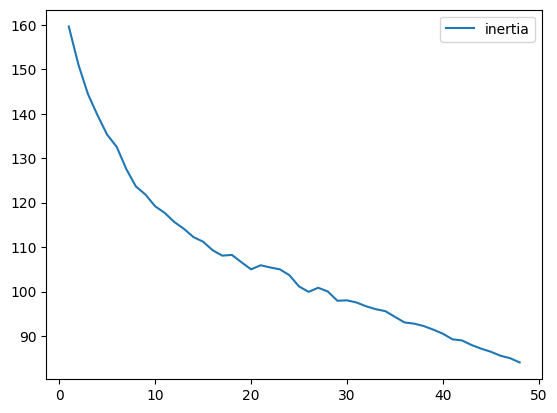

In [41]:
inertia_df.plot()

представим инерцию и ее производную в нормальном виде

In [42]:
inertia_arr = np.array(inertia_df).flatten()
inertia_derivative = inertia_arr[:-1] - inertia_arr[1:]

Тут не пугаться - это просто класс для град спуска

In [43]:
class GradSearch(object):
    def __init__(self, a=1.0, b=0.0, x0=1.0, l=1e-2):
        self.a = a
        self.b = b
        self.x0 = x0
        self.l = l
        self.loss = []

    def f(self, x, y, a, b, x0):
        return 0.5 * pow(y - a * np.exp(-x / x0) - b, 2).sum()

    def dfda(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * np.exp(-x / x0)).sum()

    def dfdb(self, x, y, a, b, x0):
        return (a * np.exp(-x / x0) + b - y).sum()

    def dfdx0(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * a * np.exp(-x / x0) * x / pow(x0, 2)).sum()

    def fit(self, x, y, epochs=1_000):
        self.loss.append(self.f(x, y, self.a, self.b, self.x0))
        for epoch in tqdm(range(epochs)):
            self.a -= self.l * self.dfda(x, y, self.a, self.b, self.x0)
            self.b -= self.l * self.dfdb(x, y, self.a, self.b, self.x0)
            self.x0 -= self.l* self.dfdx0(x, y, self.a, self.b, self.x0)
            self.loss.append(self.f(x, y, self.a, self.b, self.x0))

    def get_a_b_x0(self):
        return self.a, self.b, self.x0

Идея такая. В физике есть радиус Дебая - такое расстояние, при котором взаимодействие уменьшается в $e$ раз. Дебаевский радиус - эффективный размер распространения взаимодействия. Давайте сделаем то же самое с инерцией - дебаевским расстоянием будет количество кластеров, на котором апроксимированная функцией $f(x)$ инерция будет уменьшаться в $e$ раз.

Изначально я хотел заменить инерцию на более гладкую $f(x) = a \cdot e^{-\frac{x}{x_0}} + b$, где $a, b, x_0$ - настраиваемые параметры - как раз град спуск для них. Но потом подумал, что можно сразу использовать дебаевский формализм к инерции без преобразования.

Использование гладкой $f(x) = a \cdot e^{\frac{x}{x_0}} + b$ позволяет убрать различные выбросы и зигзаги (например, у производной инерции - там ваще свистопляска происходит).

In [44]:
x, y = np.array(range(inertia_arr.shape[0])), np.array(inertia_arr).flatten()
y_norm = y.max()
y /= y_norm

grad = GradSearch(a=1.0, b=0.0, x0=1.0, l=1e-2)
grad.fit(x, y, epochs=100_000)

100%|██████████| 100000/100000 [00:12<00:00, 8237.13it/s]


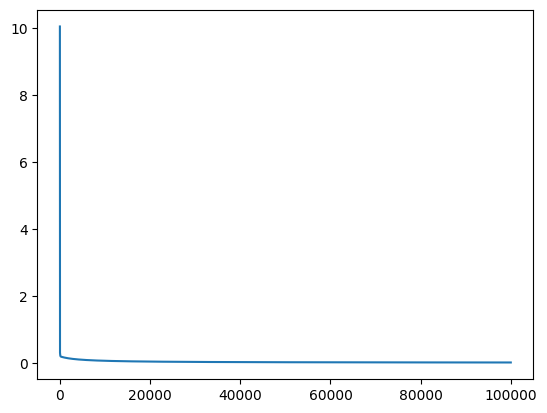

In [45]:
plt.plot(grad.loss)

In [46]:
a, b, x0 = grad.get_a_b_x0()
a, b, x0

(0.42154819776017766, 0.5744816277003394, 10.194016187026902)

In [47]:
ind = np.ceil(x0).astype(int)
ind

11

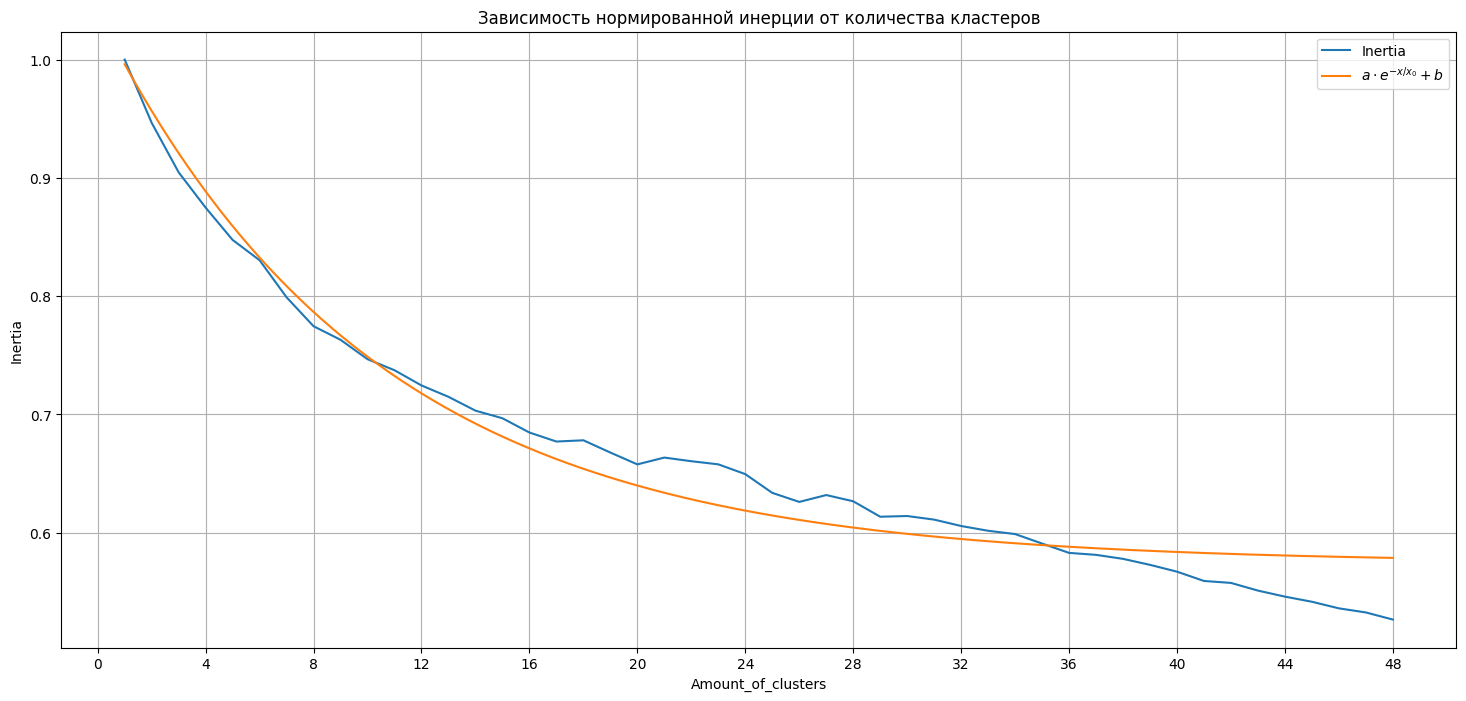

In [48]:
t = np.linspace(x.min(), x.max(), 1000)
y_pred = a * np.exp(-t / x0) + b

plt.figure(figsize=(18, 8))
plt.title('Зависимость нормированной инерции от количества кластеров')
plt.plot(x + 1, y.flatten(), label='Inertia')
plt.plot(t + 1, y_pred, label='$a \cdot e^{-x/x_0} + b$')
#plt.axhline(y=(a + b) / np.e, color='r', linestyle='--', linewidth=2, label='$y = \dfrac{1}{e} \simeq 0.368$')
plt.xticks(range(0, inertia_arr[1:].shape[0] + 4, 4))
plt.xlabel('Amount_of_clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()

Кластеризуем в соответствии с найденными кластерами

In [49]:
n_clusters = ind + 1
centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(word_vectors)

df = pd.DataFrame(lemmas, columns=['word'])
df['cluster'] = cluster_labels

Выберем рандомное слово в каждом кластере и посчитаем сколько слов всего в кластере

In [50]:
counter = {}
for i in range(n_clusters):
    w = np.random.choice(df[df['cluster'] == i]['word'])
    amount = df[df['cluster'] == i].shape[0]
    if len(w.split()) == 1:
        counter[w] = amount
    else:
        counter[dict_lemmas_to_words[w]] = amount
counter

{'систематическое обучение': 20,
 'удобный график': 30,
 'кросс-функциональное сотрудничество': 45,
 'творческий подход': 31,
 'предприимчивость': 34,
 'работа с мотивированными людьми': 44,
 'систематизация знаний': 26,
 'сотрудничество между отделами': 30,
 'команда единомышленников': 21,
 'обратная связь от коллег': 32,
 'создание новых идей': 42,
 'разнообразие задач': 26}

Визуализируем (в **seaborn** конечно же)

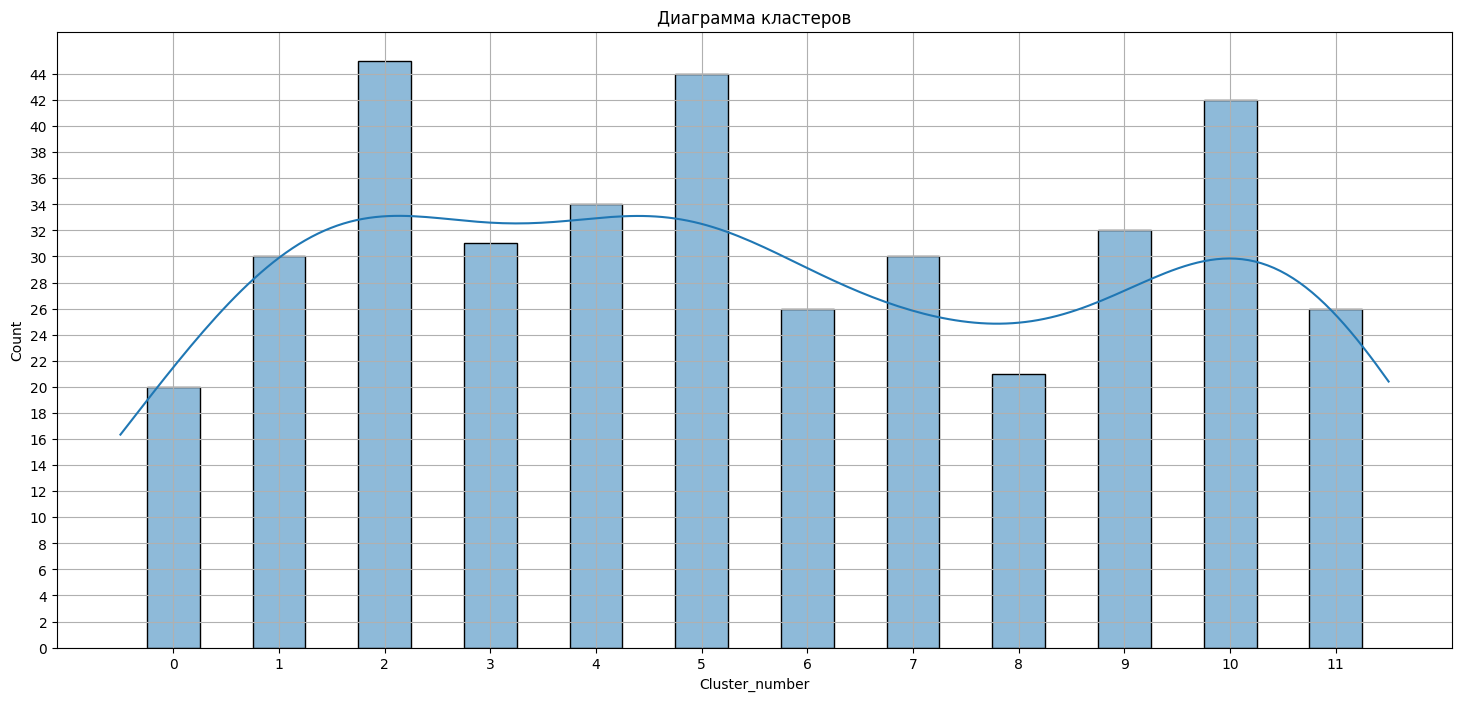

In [51]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(cluster_labels, bins=n_clusters, shrink=0.5, kde=True)

# Получаем положение каждого столбца
bin_edges = ax.patches[0].get_bbox().bounds

# Получаем центры столбцов
centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

plt.title('Диаграмма кластеров')
# Устанавливаем тики в центре каждого столбца
plt.xticks(centers, np.arange(n_clusters))
plt.yticks(range(0, max(counter.values()) + 1, 2))
plt.xlabel('Cluster_number')
plt.grid()

# Отображение графика
plt.show()

Визуализируем

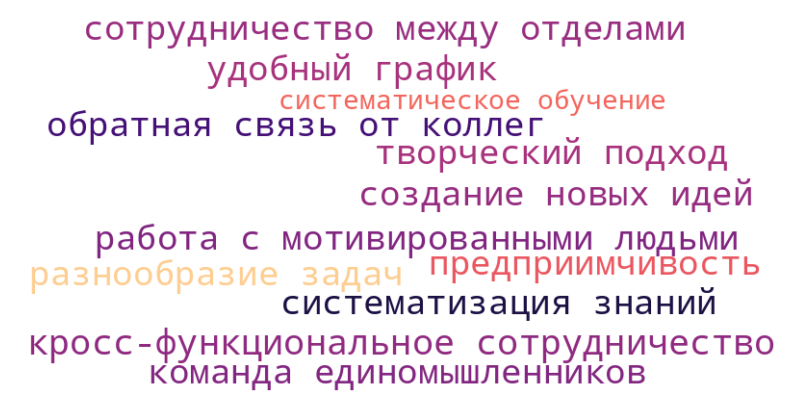

In [54]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', relative_scaling=0).generate_from_frequencies(counter)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()